In [19]:
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

from RANSAC import get_codirectional_lines

In [20]:
image = cv2.imread('images/obl3.jpg')
image.shape

(4000, 3000, 3)

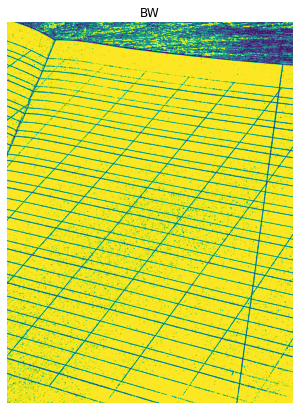

In [21]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
dilated = cv2.morphologyEx(gray, cv2.MORPH_DILATE, kernel)
median = cv2.medianBlur(dilated, 5)
diff2 = 255 - cv2.subtract(median, gray)
normed = cv2.normalize(diff2,None, 10, 255, cv2.NORM_MINMAX )
bw = cv2.threshold(normed, 235, 255, cv2.THRESH_BINARY)[1]

edges = cv2.Canny(bw, 200, 120, apertureSize=3, L2gradient=True)

plt.figure(figsize=(7,7))
plt.clf()
plt.axis("off")
plt.title("BW")
plt.imshow(bw)

In [22]:
lines = cv2.HoughLines(edges, 1, np.pi/360, 700,)
lines_points = np.empty((len(lines), 4), dtype=int)
lines_coefs = np.empty((len(lines), 3))
coef = max(image.shape)

for i, line in enumerate(lines):
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + coef*(-b))
        y1 = int(y0 + coef*(a))
        x2 = int(x0 - coef*(-b))
        y2 = int(y0 - coef*(a))
        lines_points[i] = (x1, y1, x2, y2)
        lines_coefs[i] = np.cross((x1, y1, 1), (x2, y2, 1))

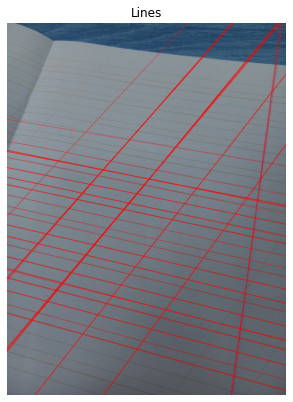

In [23]:
img_copy = image.copy()
for i, (x1, y1, x2, y2) in enumerate(lines_points):
    cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0),2)
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

In [24]:
print(f"found lines: {len(lines_coefs)}")  
line_group1, mask, v_point1 = get_codirectional_lines(lines_coefs, iters=1000, epsilon=0.005)
print(f"lines in group 1: {len(line_group1)}")
lines_points1 = lines_points[mask]

found lines: 51
lines in group 1: 20


In [25]:
lines_points = lines_points[~mask]
line_group2, mask, v_point2 = get_codirectional_lines(lines_coefs[~mask], iters=1000, epsilon=0.005)
print(f"lines in group 2: {len(line_group2)}")
lines_points2 = lines_points[mask]

lines in group 2: 10


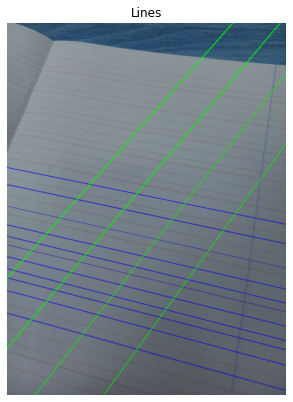

In [26]:
img_copy = image.copy()
    
for i, (x1, y1, x2, y2) in enumerate(lines_points1):
    if abs(v_point1[0]/v_point1[1]) < 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (255,0,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,0, 255),2)
for i, (x1, y1, x2, y2) in enumerate(lines_points2):
    if abs(v_point2[0]/v_point2[1]) > 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,255,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,0, 255),2)

plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

In [27]:
def find_axis(v_inf1, v_inf2):  
    
    v_inf1 = v_inf1 / np.linalg.norm(v_inf1)
    v_inf2 = v_inf2 / np.linalg.norm(v_inf2)
    
    #discribe all possible directions of vp
    dirs = np.array([[v_inf1[0], -v_inf1[0], v_inf2[0], -v_inf2[0]],
                    [v_inf1[1], -v_inf1[1], v_inf2[1], -v_inf2[1]],
                    [v_inf1[2], -v_inf1[2], v_inf2[2], -v_inf2[2]]]) 
    
    #calculate angles between Ox and each point
    thetas = np.arctan2(dirs[0], dirs[1])
    #get idx of the most closest to +Ox axis point 
    horisont_vp_idx = np.argmin(np.abs(thetas)) 
    #get idx the most closest to +Oy axis point
    if horisont_vp_idx//2 == 0:
        vertical_vp_idx = 2 + np.argmax(thetas[2:])
    else:
        vertical_vp_idx = np.argmax(thetas[:2])

    print(f'points idxs:   h - {horisont_vp_idx}, v - {vertical_vp_idx}')    
    hor_v_point = dirs[:, horisont_vp_idx]
    vert_v_point = dirs[:, vertical_vp_idx] 

    return hor_v_point, vert_v_point

In [28]:
y_p, x_p  = find_axis(v_point1, v_point2)
y_p, x_p

points idxs:   h - 2, v - 1


(array([-7.46531274e-01,  6.65350323e-01, -6.50298420e-05]),
 array([ 9.91947505e-01,  1.26649697e-01, -4.80934237e-05]))

In [76]:
def find_homography(hor_point, vert_point, intersec_angle_degrees, shift=None):
    #rotate the vertical v.p. to get pi/2 angle between horizontal v.p. and vertical v.p.
    angle = math.radians(90-intersec_angle_degrees)
    cs = np.cos(angle);
    sn = np.sin(angle);  
    vert_point_new = [
        vert_point[0] * cs + vert_point[1] * sn,
        vert_point[1] * cs - vert_point[0] * sn,
        vert_point[2]
    ]
    
    #finding homography
    H = np.eye(3)
    H[0] = np.cross(vert_point_new, np.cross(hor_point, vert_point_new)) 
    H[1] = np.cross(np.cross(hor_point, vert_point_new), hor_point)
    H[2] = np.cross(hor_point, vert_point_new)
    
#     H[0] = H[0]/np.linalg.norm(H.dot(hor_point)) 
#     H[1] = H[1]/np.linalg.norm(H.dot(vert_point_new))
    if np.linalg.det(H) < 0:
        H[:, 0] = -H[:, 0]
    
    if shift:
        T = np.array([
            [1., 0., -1000.],
            [0., 1., -1000.],
            [0., 0.,   1.]
        ])
        T_1 = np.linalg.inv(T)
        H = np.matmul( H, T)
    return H

In [77]:
homography = find_homography(x_p, y_p, 60, shift=True)

(4000, 3000, 3)

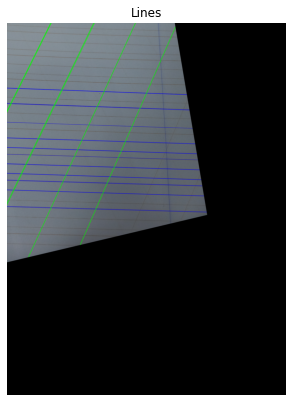

In [78]:
img_copy_new = cv2.warpPerspective(img_copy, homography, (3000, 4000)) 
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy_new)
img_copy_new.shape